In [2]:
input_3sat_instance = """
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
"""

In [10]:
import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError
from qiskit.circuit.library.phase_oracle import PhaseOracle

fp = tempfile.NamedTemporaryFile(mode="w+t", delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)
finally:
    os.remove(file_name)


In [11]:
from qiskit_algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

print(oracle)
print(problem)

          ┌───┐┌───┐┌───┐   
q_0: ──■──┤ X ├┤ Z ├┤ X ├─o─
       │  └───┘└───┘└───┘ │ 
q_1: ──■──────────────────■─
     ┌───┐                │ 
q_2: ┤ Z ├────────────────o─
     └───┘                  


In [12]:
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)

011


C:\Users\admin\AppData\Local\Temp/ipykernel_8668/852366760.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


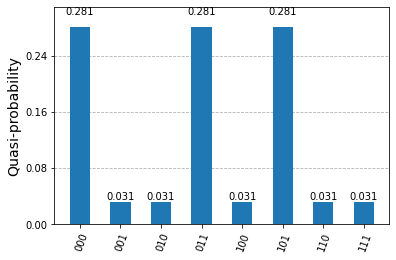

In [13]:
from qiskit.visualization import plot_histogram

if result is not None:
    display(plot_histogram(result.circuit_results[0]))

if result is None:
    print(result)

C:\Users\admin\AppData\Local\Temp/ipykernel_8668/1354232209.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


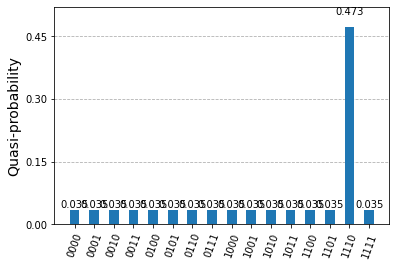

In [9]:
expression = "(w ^ x) & ~(y ^ z) & (x & y & z)"
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    grover = Grover(sampler=Sampler())
    result = grover.amplify(problem)
    display(plot_histogram(result.circuit_results[0]))
except MissingOptionalLibraryError as ex:
    print(ex)
